# 합격/불합격 분류 모델(RandomForest)
#### 60170029 이종언

# 1) 데이터 로딩
### 1-1) 라이브러리 불러오기

In [1]:
#pandas, numpy 호출
import pandas as pd 
import numpy as np
#sklearn 호출
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets
#sklearn 스플리터
from sklearn.model_selection import train_test_split #X,Y값 Splitter
#랜덤포레스트 라이브러리
from sklearn.ensemble import RandomForestClassifier
#모델평가 라이브러리
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

### 1-2) 데이터프레임으로 데이터 읽어오기

In [2]:
df = pd.read_csv("student.csv") #csv 데이터 입력, 칼럼인덱스 미사용
df.head() #불러온 데이터프레임 상위 8개값 호출

,gre,gpa,rank,sex,age,nationality,admission
0,380.0,3.61,3,f,19,Korea,불합격
1,660.0,3.67,3,f,18,Korea,NaN
2,800.0,4.00,1,m,19,Korea,합격
3,NaN,3.19,4,m,19,Korea,합격
4,520.0,2.93,4,f,19,Korea,불합격


# 2) 데이터 확인

## 결측치 확인

In [3]:
df.isnull().sum()

gre            2
gpa            2
rank           0
sex            0
age            0
nationality    0
admission      2
dtype: int64

#### gre 칼럼과 gpa 칼럼, admission 칼럼에 2개씩 결측치가 확인된다.

In [4]:
print('Column 수 : %s' % df.shape[0]) #칼럼수 카운트
print('Row 수 : %s' % df.shape[1]) #레코드수 카운트
print('\n[Column 리스트]\n',df.columns.tolist()) #칼럼 뭐가있는지 확인 (df.columns.unique() 도 가능)
print('\n[데이터프레임 정보]')
df.info() #데이터프레임의 정보 표시
print('\n[통계]')
df.describe() #데이터프레임의 각 칼럼의 통계정보 표시

# [각 칼럼 이해]
# gre - GRE 점수
# gpa - 학점
# rank – 등급
# sex – 성별
# age – 나이S
# nationality – 국적
# admission – 합격 여부


Column 수 : 400
Row 수 : 7

[Column 리스트]
 ['gre', 'gpa', 'rank', 'sex', 'age', 'nationality', 'admission']

[데이터프레임 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gre          398 non-null    float64
 1   gpa          398 non-null    float64
 2   rank         400 non-null    int64  
 3   sex          400 non-null    object 
 4   age          400 non-null    int64  
 5   nationality  400 non-null    object 
 6   admission    398 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 22.0+ KB

[통계]


,gre,gpa,rank,age
count,398.000000,398.000000,400.00000,400.000000
mean,587.889447,3.389497,2.48500,19.025000
std,115.599708,0.381268,0.94446,0.809948
min,220.000000,2.260000,1.00000,17.000000
25%,520.000000,3.130000,2.00000,19.000000
50%,580.000000,3.395000,2.00000,19.000000
75%,660.000000,3.670000,3.00000,19.000000
max,800.000000,4.000000,4.00000,22.000000


#### sex, admission 값은 현재 object 로 입력되어있어 매핑 혹은 인코딩이 필요하다. nationality 칼럼은 제거할 것이다.

# 3) 데이터 전처리

## 3-1) sex 칼럼 수치화 및 원핫인코딩 (남자 : 0 / 여자 : 1)

In [5]:
df["sex"] = df.sex.map(lambda x: 0 if x=='m' else 1) #람다 함수로 매핑
df.head(6)

,gre,gpa,rank,sex,age,nationality,admission
0,380.0,3.61,3,1,19,Korea,불합격
1,660.0,3.67,3,1,18,Korea,NaN
2,800.0,4.00,1,0,19,Korea,합격
3,NaN,3.19,4,0,19,Korea,합격
4,520.0,2.93,4,1,19,Korea,불합격
5,760.0,3.00,2,1,19,Korea,합격


#### nationality 칼럼 매핑 완료

##### Sex 칼럼 원핫인코딩

In [6]:
onehot = pd.get_dummies(df['sex'], prefix = 'sex')
df.drop(['sex'], axis = 1, inplace = True)
df = df.join(onehot)
df.head()

,gre,gpa,rank,age,nationality,admission,sex_0,sex_1
0,380.0,3.61,3,19,Korea,불합격,False,True
1,660.0,3.67,3,18,Korea,NaN,False,True
2,800.0,4.00,1,19,Korea,합격,True,False
3,NaN,3.19,4,19,Korea,합격,True,False
4,520.0,2.93,4,19,Korea,불합격,False,True


# 3-2)  국적 칼럼 제거

In [7]:
df.drop('nationality', axis = 1, inplace= True)
df.head()

,gre,gpa,rank,age,admission,sex_0,sex_1
0,380.0,3.61,3,19,불합격,False,True
1,660.0,3.67,3,18,NaN,False,True
2,800.0,4.00,1,19,합격,True,False
3,NaN,3.19,4,19,합격,True,False
4,520.0,2.93,4,19,불합격,False,True


## 3-3) admission 칼럼 수치화 (불합격 : 0 / 합격 : 1)

#### admission 칼럼은 이번에 gre 및 gpa 결측치 채우기에 사용할 예정이므로 목표변수 뿐 아니라 선형회귀모델의 속성으로도 사용되므로 편의상 수치화하였다.

In [8]:
divadm = {'불합격':0, '합격':1} #Dictionary 로 매핑
df["admission"] = df.admission.map(divadm)
df.head(5)

,gre,gpa,rank,age,admission,sex_0,sex_1
0,380.0,3.61,3,19,0.0,False,True
1,660.0,3.67,3,18,NaN,False,True
2,800.0,4.00,1,19,1.0,True,False
3,NaN,3.19,4,19,1.0,True,False
4,520.0,2.93,4,19,0.0,False,True


## 3-4) 수치화 결과 확인

In [9]:
print('\n[데이터프레임 정보]')
df.info() #데이터프레임의 정보 표시


[데이터프레임 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gre        398 non-null    float64
 1   gpa        398 non-null    float64
 2   rank       400 non-null    int64  
 3   age        400 non-null    int64  
 4   admission  398 non-null    float64
 5   sex_0      400 non-null    bool   
 6   sex_1      400 non-null    bool   
dtypes: bool(2), float64(3), int64(2)
memory usage: 16.5 KB


#### 모든 칼럼이 수치화되었다.

## 3-5 ) 탐색적 데이터 분석과정(EDA) 을 통한 결측치 보간

In [10]:
# gre - 대학원 입학 시험 점수
# gpa - 대학 학점
# rank – 학생 등급
# sex – 성별
# age – 나이
# nationality – 국적
# admission – 합격 여부

### 합격과 불합격 비율

In [11]:
df['admission'].value_counts()

admission
0.0    272
1.0    126
Name: count, dtype: int64

약 46.32%의 합격률을 보이고 있다.

#### Rank 에 따른 합격자 비율

In [12]:
df.groupby('rank')['admission'].value_counts()

rank  admission
1     1.0          33
      0.0          28
2     0.0          97
      1.0          54
3     0.0          92
      1.0          27
4     0.0          55
      1.0          12
Name: count, dtype: int64

<Axes: >

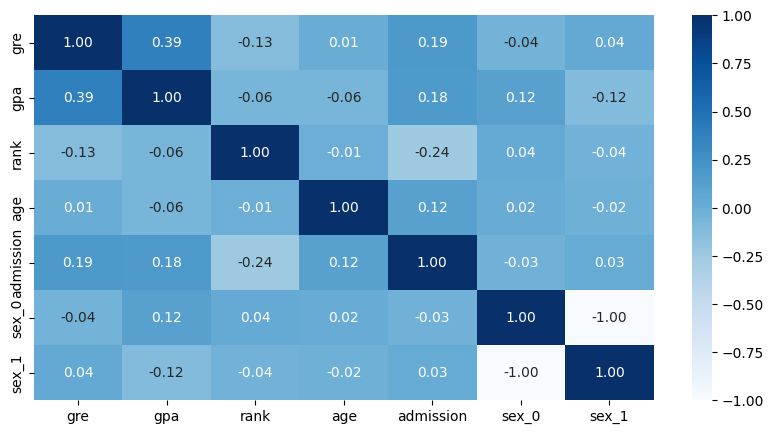

In [13]:
import seaborn as sns #seaborn 호출
import matplotlib.pyplot as plot #plot 호출
plot.figure(figsize=(10,5)) #10x5 크기로 설정
eda_corr = df.corr()
sns.heatmap(data = eda_corr, annot=True, fmt = '0.2f', cmap='Blues')
#상관계수분석 기반 heatmap 작성, 수치(annot) 표시, 표시형식은 소숫점 2자리까지, 컬러는 블루

#### 시험 합격/불합격 여부와 연관이 큰 속성은 Rank, gre, gpa, age 순이다..

##### 0) 합격/불합격 값이 결측치인 행을 gre, gpa 값을 예측하는 데 사용하기로 하여 아래의 코드는 미사용한다.
##### df = df.dropna(axis=0, subset=['admission']) // admission 칼럼에 결측치가 있는 행 모두 삭제
##### 1) gre 와 gpa 는 연속된 값이므로 admission 과 rank 로 그룹지어 해당 학생이 속한 그룹의 중간값으로 결측치를 채울 수 있다.
##### df = df.groupby(['admission', 'rank'])['gre'].apply(lambda x: x.fillna(x.median()))
##### 2) gre/gpa 값은 레코드 순서대로 연속되지 않기에 interpolate() 함수를 사용하여 선형보간법을 사용하기 적절하지 않다.
#### 
#### gre값은 gpa 값과 상관계수가 높으며, gpa 값은 gre 값과 상관계수가 없다.
#### 또한 gre값과 gpa 값은 float 타입의 연속값이다.
#### 이에 gre 에는 gpa, admision 값을, gpa 에는 gre,admission 값을 이용하여 선형회귀모델을 만들어 대체하기로 하였다.

## 3-5-1) gpa, admission 값으로 gre 결측치 채우기

In [14]:
df.head()

,gre,gpa,rank,age,admission,sex_0,sex_1
0,380.0,3.61,3,19,0.0,False,True
1,660.0,3.67,3,18,NaN,False,True
2,800.0,4.00,1,19,1.0,True,False
3,NaN,3.19,4,19,1.0,True,False
4,520.0,2.93,4,19,0.0,False,True


In [15]:
from sklearn import linear_model #선형회귀모델 호출
X0 = df.dropna(axis=0)[['gpa','admission']] #gpa와 admission 칼럼의 결측지가 있는 레코드를 제거한 뒤 속성값으로 활용
Y0 = df.dropna(axis=0)['gre'] #gre값을 목표변수로 활용
#numpy array 로 변환
X0 = np.array(X0.iloc[:,:])
Y0 = np.array(Y0.iloc[:])
print('[X속성]\n',X0)
print('[Y목표변수]\n',Y0)

[X속성]
 [[3.61 0.  ]
 [4.   1.  ]
 [2.93 0.  ]
 [3.   1.  ]
 [2.98 1.  ]
 [3.08 0.  ]
 [3.39 1.  ]
 [3.92 0.  ]
 [4.   0.  ]
 [3.22 0.  ]
 [4.   1.  ]
 [3.08 0.  ]
 [4.   1.  ]
 [3.44 0.  ]
 [3.87 0.  ]
 [2.56 0.  ]
 [3.75 0.  ]
 [3.81 1.  ]
 [3.63 1.  ]
 [2.82 0.  ]
 [3.19 0.  ]
 [3.35 1.  ]
 [3.66 1.  ]
 [3.61 1.  ]
 [3.74 1.  ]
 [3.22 1.  ]
 [3.78 0.  ]
 [3.35 0.  ]
 [3.4  0.  ]
 [4.   1.  ]
 [3.14 0.  ]
 [3.05 0.  ]
 [3.25 0.  ]
 [2.9  0.  ]
 [3.13 1.  ]
 [2.68 1.  ]
 [2.42 0.  ]
 [3.32 1.  ]
 [3.15 1.  ]
 [3.31 0.  ]
 [2.94 0.  ]
 [3.45 1.  ]
 [3.46 1.  ]
 [2.97 0.  ]
 [2.48 0.  ]
 [3.35 0.  ]
 [3.86 0.  ]
 [3.13 0.  ]
 [3.37 0.  ]
 [3.27 1.  ]
 [3.34 0.  ]
 [4.   1.  ]
 [3.19 0.  ]
 [2.94 0.  ]
 [3.65 0.  ]
 [2.82 0.  ]
 [3.18 1.  ]
 [3.32 0.  ]
 [3.67 0.  ]
 [3.85 1.  ]
 [4.   0.  ]
 [3.59 0.  ]
 [3.62 0.  ]
 [3.3  0.  ]
 [3.69 0.  ]
 [3.73 0.  ]
 [4.   0.  ]
 [2.92 0.  ]
 [3.39 0.  ]
 [4.   0.  ]
 [3.45 0.  ]
 [4.   0.  ]
 [3.36 0.  ]
 [4.   1.  ]
 [3.12 0.  ]
 [4.   1.  ]
 [2.9

In [16]:
lin_gre = linear_model.LinearRegression() #선형회귀모델 생성
lin_gre_model = lin_gre.fit(X0,Y0) #모델적합

# 이 부분은 gpa 값과 admission 값이 없어서 오류발생하는 걸 방지하기 위해 선형회귀모델에 X속성의 결측치에 임의의 값을 집어넣는 과정#
dftemp0 = df.copy() #새로운 테이블을 만들어 선형회귀모델의 목표변수로만 채울 테이블을 만들었고 여기서 선형모델을 적용할 것이다.

dftemp0.gpa.fillna(df.gpa.median(), inplace=True) #중간값으로 뗴움
dftemp0.admission.fillna(0.5, inplace=True) #결측치의 합격여부는 0.5로 떼움

In [17]:
#테이블의 gpa, admission 칼럼값으로 gre 값을 예측하게 함
y_pred_gre = lin_gre_model.predict(dftemp0.loc[:, ['gpa','admission']].values) #iloc 는 [:,0:2] 이런식이면 loc 는 [:, ['칼럼명']] 으로 더 인간친화적
#.values 를 붙인 이유 : 선형모델 피팅을 array 로 했기 때문에 데이터프레임 형식인 dftemp0 의 value 만 따와서 예측하게 함
y_pred_gre

array([602.54570758, 624.3852004 , 675.96048209, 586.7531155 ,
       527.65557266, 565.82793074, 563.62527971, 544.17545536,
       608.77962577, 636.68679849, 645.4974026 , 559.59401255,
       675.96048209, 544.17545536, 675.96048209, 583.82317385,
       631.18017093, 486.90652867, 617.96426477, 655.03529733,
       569.31892473, 635.21143809, 515.54099201, 556.29003601,
       604.37432371, 638.51541463, 633.00878706, 647.32601874,
       590.05709204, 578.86720904, 621.26824131, 573.91124423,
       579.41787179, 675.96048209, 550.78340845, 540.87147882,
       562.89798909, 524.35159612, 580.14516242, 530.58551431,
       471.48797148, 601.07034717, 582.34781344, 569.50594217,
       528.75689818, 615.38757885, 616.48890436, 532.06087472,
       478.09592456, 573.91124423, 630.07884541, 549.68208293,
       576.11389525, 595.5637196 , 572.80991871, 675.96048209,
       556.29003601, 528.75689818, 606.95100963, 515.54099201,
       585.65178998, 570.60726769, 609.15366066, 659.44

In [18]:
df['gre'].fillna(pd.Series(y_pred_gre.flatten()), inplace=True) #y_pred_gre 는 2D array 이므로 1D array 로 평탄화, Series 데이터로 변환
#gre 행의 결측치에 선형회귀모델 예측결과 입력
df

,gre,gpa,rank,age,admission,sex_0,sex_1
0,380.000000,3.61,3,19,0.0,False,True
1,660.000000,3.67,3,18,NaN,False,True
2,800.000000,4.00,1,19,1.0,True,False
3,586.753115,3.19,4,19,1.0,True,False
4,520.000000,2.93,4,19,0.0,False,True
...,...,...,...,...,...,...,...
395,620.000000,4.00,2,20,0.0,False,True
396,560.000000,3.04,3,18,0.0,True,False
397,460.000000,2.63,2,19,0.0,True,False
398,700.000000,NaN,2,19,0.0,True,False


## 3-5-2) gre, admission 값으로 gpa 결측치 채우기

In [19]:
# 3-5-1 과 동일한 방법
X1 = df.dropna(axis=0)[['gre','admission']] #gre와 admission 칼럼의 결측지가 있는 레코드를 제거한 뒤 속성값으로 활용
Y1 = df.dropna(axis=0)['gpa'] #gpa값을 목표변수로 활용
X1 = np.array(X1.iloc[:,:])
Y1 = np.array(Y1.iloc[:])
print('[X속성]\n',X1)
print('[Y목표변수]\n',Y1)

[X속성]
 [[380.          0.       ]
 [800.          1.       ]
 [586.7531155   1.       ]
 [520.          0.       ]
 [760.          1.       ]
 [560.          1.       ]
 [400.          0.       ]
 [540.          1.       ]
 [700.          0.       ]
 [800.          0.       ]
 [440.          0.       ]
 [760.          1.       ]
 [700.          0.       ]
 [700.          1.       ]
 [480.          0.       ]
 [780.          0.       ]
 [360.          0.       ]
 [800.          0.       ]
 [540.          1.       ]
 [660.          1.       ]
 [600.          0.       ]
 [680.          0.       ]
 [760.          1.       ]
 [800.          1.       ]
 [620.          1.       ]
 [520.          1.       ]
 [780.          1.       ]
 [540.          0.       ]
 [760.          0.       ]
 [600.          0.       ]
 [800.          1.       ]
 [360.          0.       ]
 [400.          0.       ]
 [580.          0.       ]
 [520.          0.       ]
 [500.          1.       ]
 [520.          1.   

In [20]:
lin_gpa = linear_model.LinearRegression() #선형회귀모델 생성
lin_gpa_model = lin_gpa.fit(X1,Y1) #모델적합

# 이 부분은 gre 값과 admission 값이 없어서 오류발생하는 걸 방지하기 위해 선형회귀모델에 X속성의 결측치에 임의의 값을 집어넣는 과정#
dftemp0 = df.copy()

dftemp0.gre.fillna(df.gre.median(), inplace=True) #중간값으로 떼움
dftemp0.admission.fillna(1, inplace=True) #1로 떼움


y_pred_gpa = lin_gpa_model.predict(dftemp0.loc[:,['gre','admission']].values) #iloc 는 [:,0:2] 이런식이면 loc 는 [:, ['칼럼명']] 으로 더 인간친화적
y_pred_gpa

array([3.11032595, 3.53658368, 3.70549624, 3.44820998, 3.27923851,
       3.65723551, 3.41593186, 3.13445632, 3.39180149, 3.4964118 ,
       3.61706363, 3.18271705, 3.65723551, 3.4964118 , 3.58484441,
       3.23097778, 3.59293326, 3.08619559, 3.61706363, 3.39180149,
       3.34354076, 3.53658368, 3.37575997, 3.47228143, 3.65723551,
       3.70549624, 3.48832295, 3.36767113, 3.68136588, 3.27923851,
       3.30336887, 3.5688029 , 3.37575997, 3.70549624, 3.08619559,
       3.13445632, 3.35162961, 3.27923851, 3.34354076, 3.36767113,
       3.32749924, 3.44006222, 3.46419259, 3.25510814, 3.4964118 ,
       3.29528003, 3.44006222, 3.25510814, 3.18271705, 3.13445632,
       3.4240207 , 3.18271705, 3.54467253, 3.56071405, 3.44815107,
       3.63310515, 3.32749924, 3.11032595, 3.13445632, 3.37575997,
       3.48832295, 3.32749924, 3.4240207 , 3.56071405, 3.35162961,
       3.37575997, 3.54467253, 3.39989034, 3.35162961, 3.61706363,
       3.4240207 , 3.01380449, 3.23097778, 3.35162961, 3.52054

In [21]:
df['gpa'].fillna(pd.Series(y_pred_gpa.flatten()), inplace=True) #y_pred_gpa 는 2D array 이므로 1D array 로 평탄화, Series 데이터로 변환
#gpa 행의 결측치에 선형회귀모델 예측결과 입력
df.tail(5)

,gre,gpa,rank,age,admission,sex_0,sex_1
395,620.0,4.000000,2,20,0.0,False,True
396,560.0,3.040000,3,18,0.0,True,False
397,460.0,2.630000,2,19,0.0,True,False
398,700.0,3.496412,2,19,0.0,True,False
399,600.0,3.890000,3,19,0.0,True,False


In [22]:
df.isnull().sum()

gre          0
gpa          0
rank         0
age          0
admission    2
sex_0        0
sex_1        0
dtype: int64

#### 모든 결측치값을 선형회귀모델을 이용하여 보간함

#### 단, 합불여부의 결측치를 1로 임의지정했기에 데이터가 왜곡되는 문제가 있다.

## 3-5-3) admission 열이 NaN인 레코드 분리보관

#### 먼저 admission 값이 NaN 인 레코드 2개를 제외하였다.

In [23]:
nulldf=pd.DataFrame() #빈 데이터프레임 생성
nulldf=df[df['admission'].isnull()] #admission 열이 null값인 레코드만 추출
nulldf #nulldf 에 분리보관

df = df.dropna(subset=['admission'], axis=0) #nationality가 Nan 인 레코드 제거

## 3-5-4) 변수분포 히스토그램 표시

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

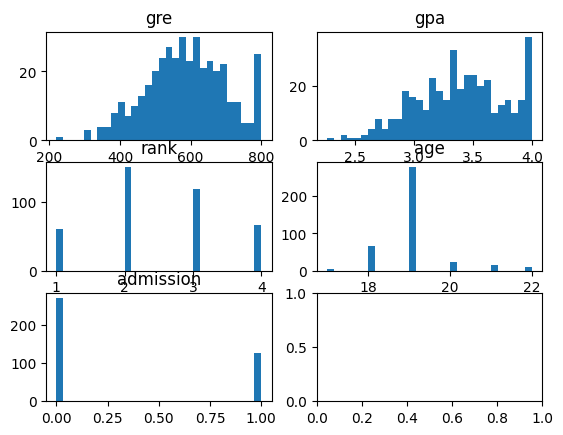

In [24]:
for i in range(df.shape[1]-1): # admisison 칼럼 미표시
    data = np.array(df.iloc[:,i]) #각 열별로 1차원 Array 에 값 저장
    plot.subplot(3,2,i+1)
    plot.hist(data,bins=30)
    plot.title(df.columns[i]) #각 서브플롯별로 Title 을 df의 칼럼명으로 입력
    
plot.tight_layout() #서브플롯별로 겹치지 않게 Layout 설정
plot.show()

# 3-6) SMOTE 밸런싱

# 2-1) 목표변수 비율 확인

In [ ]:
import matplotlib.pyplot as plot
#바그래프 출력(x값, height 값)
plot.bar(df['admission'].unique(), df['admission'].value_counts().tolist())
#plot.hist(data,bins=4) // 미사용, 2차원 데이터를 통째로 plot 에 히스토그램으로 넣을때
plot.show()

##### 목표변수의 비율이 비대칭으로 SMOTE 밸런싱을 진행할 것이다.

In [ ]:
X = np.array(df.iloc[:,:5]) #admission 열 제외 모든 열 집어넣기, 속성값 X로 저장
Y = np.array(df['admission']) #admission 값을 목표변수 Y로 저장
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12345)

In [ ]:
from imblearn.over_sampling import SMOTE
#SMOTE 객체 생성
sm = SMOTE(random_state=0)
#X,Y값을 리샘플링
X_train_sampled, Y_train_sampled = sm.fit_resample(X_train,Y_train)

#countplot 표시
import seaborn as sns
sns.countplot(x=Y_train_sampled)

#### 합격변수와 불합격변수의 밸런싱이 되었다.

# 4) 랜덤포레스트 모델 적합

# 4-1 ) 최적 나무수 탐색

In [ ]:
#정확도 점수 저장할 리스트 생성
scores = list()
#1~100까지 수행(5씩 증가)
for i in range(10,200,5):
    #i 변수 지정
    RF = RandomForestClassifier(n_estimators=i, random_state=0)
    #모델 적합
    RF.fit(X_train_sampled, Y_train_sampled)
    RFpred = RF.predict(X_test)
    res = accuracy_score(Y_test, RFpred)
    scores.append(res)
    
    print('> 나무수 : %d, 정확도: %.3f' %(i, res))

##### 나무수가 10개일 대 가장 정확도가 높다.

## 4-2) 최적값으로 모델 적합

In [ ]:
RF = RandomForestClassifier(n_estimators = 10, random_state = 0)
RF.fit(X_train_sampled, Y_train_sampled)
RFpred = RF.predict(X_test)

## 5) 모델 성능 평가(랜덤포레스트)

In [ ]:
print('[랜덤포레스트 초기모델 평가]')
print('정확도 : %0.3f' % accuracy_score(Y_test, RFpred))

# 추가) 스케일링 방법별 모델비교

## A1) Standard Scaler

In [ ]:
# 라이브러리 호출
from sklearn.preprocessing import StandardScaler

# SS 객체 생성 및 적합
ss = StandardScaler()
ss.fit(X_train_sampled)
#신규변수 생성
X_train_sampled_ss = ss.transform(X_train_sampled)
X_test_ss = ss.transform(X_test)

# A1-1) Standard Scaler 최적나무수 탐색

In [ ]:
#정확도 점수 저장할 리스트 생성
scores1 = list()
#1~100까지 수행(5씩 증가)
for i in range(10,200,5):
    #i 변수 지정
    RF1 = RandomForestClassifier(n_estimators=i, random_state=0)
    #모델 적합
    RF1.fit(X_train_sampled_ss, Y_train_sampled)
    RF1pred = RF1.predict(X_test_ss)
    res = accuracy_score(Y_test, RF1pred)
    scores1.append(res)
    
    print('> 나무수 : %d, 정확도: %.3f' %(i, res))

##### SMOTE + Standard Scaler 의 최적 나무 수는 20개이다.

## A1-2) Standard Scaler 최적값으로 재적합

In [ ]:
RF1 = RandomForestClassifier(n_estimators=20, random_state=0)
RF1.fit(X_train_sampled_ss, Y_train_sampled)
RF1pred = RF1.predict(X_test_ss)
print('정확도 : %0.3f' % accuracy_score(Y_test, RF1pred))

## A1-2 ) Standard Scaler 전후비교

In [ ]:
X_train_sampled_ss.shape

In [ ]:
import matplotlib.pyplot as plt
#442x5 = 2210
SSAfter = X_train_sampled_ss.reshape(2210,1)
SSBefore = X_train_sampled.reshape(2210,1)

In [ ]:
plt.hist(SSBefore, bins=30, color= 'red', alpha = 0.7)
plt.title('before data scaling')
plt.show()

In [ ]:
plt.hist(SSAfter, bins=30, alpha = 0.7, density = True)
plt.title('StandardScaler')
plt.show()

## A2) MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#MinMaxScaler 객체 생성
mms = MinMaxScaler()
#MinMaxScaler 모델 적합
mms.fit(X_train_sampled)
#MinMaxScaler 변수 변환
X_train_sampled_mms = mms.transform(X_train_sampled)
X_test_mms = mms.transform(X_test)
#이전에 만들어둔 의사결정나무 재적합

# A2-1) MinMaxScaler 최적값 탐색

In [ ]:
#정확도 점수 저장할 리스트 생성
scores2 = list()
#1~100까지 수행(5씩 증가)
for i in range(10,200,5):
    #i 변수 지정
    RF2 = RandomForestClassifier(n_estimators=i, random_state=0)
    #모델 적합
    RF2.fit(X_train_sampled_mms, Y_train_sampled)
    RF2pred = RF2.predict(X_test_mms)
    res = accuracy_score(Y_test, RF2pred)
    scores2.append(res)
    
    print('> 나무수 : %d, 정확도: %.3f' %(i, res))

##### SMOTE + MinMaxScaler 모델의 최적 나무수는 25이다.

# A2-2 )최적갑으로 모델 재적합

In [ ]:
RF2 = RandomForestClassifier(n_estimators=25, random_state=0)
RF2.fit(X_train_sampled_mms, Y_train_sampled)
RF2pred = RF2.predict(X_test_mms)
print('정확도 : %0.3f' % accuracy_score(Y_test, RF2pred))

# A3 MinMaxScaler 모델 변수 분포 확인

In [ ]:
X_train_sampled.shape

In [ ]:
MMAfter = X_train_sampled_mms.reshape(2210,1)
plt.hist(MMAfter, bins = 30, color = 'orange', alpha = 0.7)
plt.title('MinMaxScaler')
plt.show()

## A3) MaxAbsScaler

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
mas = MaxAbsScaler()
mas.fit(X_train_sampled)
X_train_sampled_mas = mas.transform(X_train_sampled)
X_test_mas = mas.transform(X_test)

# A3-1) MaxAbsScaler 최적나무수 탐색

In [ ]:
#정확도 점수 저장할 리스트 생성
scores3 = list()
#1~100까지 수행(5씩 증가)
for i in range(10,200,5):
    #i 변수 지정
    RF3 = RandomForestClassifier(n_estimators=i, random_state=0)
    #모델 적합
    RF3.fit(X_train_sampled_mas, Y_train_sampled)
    RF3pred = RF3.predict(X_test_mas)
    res = accuracy_score(Y_test, RF3pred)
    scores3.append(res)
    
    print('> 나무수 : %d, 정확도: %.3f' %(i, res))

##### SMOTE  + MaxAbsScaler 의 최적 나무 수는 20 개이다.

# A3-2) 최적값으로 MaxAbsScaler 모델 적합

In [ ]:
RF3 = RandomForestClassifier(n_estimators=20, random_state=0)
RF3.fit(X_train_sampled_mas, Y_train_sampled)
RF3pred = RF3.predict(X_test_mas)
print('정확도 : %0.3f' % accuracy_score(Y_test, RF3pred))

# A3-3) MaxAbsScaler 변수 분포 확인

In [ ]:
MASAfter = X_train_sampled_mas.reshape(2210,1)
plt.hist(MASAfter, bins = 30, color = 'blue', alpha = 0.7)
plt.title('MaxAbsScaler')
plt.show()

## A4) RobustScaler

In [ ]:
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
rbs.fit(X_train_sampled)

#모델 적합
X_train_sampled_rbs = rbs.transform(X_train_sampled)
X_test_rbs = rbs.transform(X_test)
#의사결정나무 생성 및 적합
dtc4 = RandomForestClassifier()

# A4-1) RobustScaler 최적나무수 탐색

In [ ]:
#정확도 점수 저장할 리스트 생성
scores4 = []
#1~100까지 수행(5씩 증가)
for i in range(10,200,5):
    #i 변수 지정
    RF4 = RandomForestClassifier(n_estimators=i, random_state=0)
    #모델 적합
    RF4.fit(X_train_sampled_rbs, Y_train_sampled)
    RF4pred = RF4.predict(X_test_rbs)
    res = accuracy_score(Y_test, RF4pred)
    scores4.append(res)
    
    print('> 나무수 : %d, 정확도: %.3f' %(i, res))

#####  SMOTE + RobustScaler 모델의 최적 나무수는 10개이다.

# A4-2) 최적나무수로 RobustScaler 모델 재적합

In [ ]:
RF4 = RandomForestClassifier(n_estimators=10, random_state=0)
RF4.fit(X_train_sampled_rbs, Y_train_sampled)
RF4pred = RF4.predict(X_test_rbs)
print('정확도 : %0.3f' % accuracy_score(Y_test, RF4pred))

# A4-3) RobustScaler 변수 분포 확인

In [ ]:
RBSAfter = X_train_sampled_rbs.reshape(2210,1)
plt.hist(RBSAfter, bins = 30, color = 'green', alpha = 0.7)
plt.title('Robust Scaler')
plt.show()

# 스케일링 방식별 모델간 성능비교

In [ ]:
plt.plot(range(10,200,5), scores, '-', label="SMOTE")
plt.plot(range(10,200,5), scores1, '-', label="SMOTE + SS")
plt.plot(range(10,200,5), scores2, '-', label="SMOTE + MinMax")
plt.plot(range(10,200,5), scores3, '-', label="SMOTE + MaxAbs")
plt.plot(range(10,200,5), scores4, '-', label="SMOTE + Robust")
plt.xlabel('Tree num')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph of each Model')
plt.legend()
plt.show()

In [ ]:
print('[SMOTE]\n')
print('정확도: %0.3f' % accuracy_score(Y_test, RFpred))
print('정밀도: %0.3f' % precision_score(Y_test, RFpred))
print('재현율: %0.3f' % recall_score(Y_test, RFpred))
print('f1-score: %0.3f' % f1_score(Y_test, RFpred))

print('')

print('[SMOTE + Standard Scaler]\n')
print('정확도: %0.3f' % accuracy_score(Y_test, RF1pred))
print('정밀도: %0.3f' % precision_score(Y_test, RF1pred))
print('재현율: %0.3f' % recall_score(Y_test, RF1pred))
print('f1-score: %0.3f' % f1_score(Y_test, RF1pred))

print('')

print('[SMOTE + MinMaxScaler]\n')
print('정확도: %0.3f' % accuracy_score(Y_test, RF2pred))
print('정밀도: %0.3f' % precision_score(Y_test, RF2pred))
print('재현율: %0.3f' % recall_score(Y_test, RF2pred))
print('f1-score: %0.3f' % f1_score(Y_test, RF2pred))

print('')

print('[SMOTE + MaxAbsScaler]\n')
print('정확도: %0.3f' % accuracy_score(Y_test, RF3pred))
print('정밀도: %0.3f' % precision_score(Y_test, RF3pred))
print('재현율: %0.3f' % recall_score(Y_test, RF3pred))
print('f1-score: %0.3f' % f1_score(Y_test, RF3pred))

print('')

print('[SMOTE + RobustScaler]\n')
print('정확도: %0.3f' % accuracy_score(Y_test, RF4pred))
print('정밀도: %0.3f' % precision_score(Y_test, RF4pred))
print('재현율: %0.3f' % recall_score(Y_test, RF4pred))
print('f1-score: %0.3f' % f1_score(Y_test, RF4pred))

##### MinMaxScaler 외에는 모델 성능 평가지표에 변화가 없었다.

# 스케일링 방식별 모델간 ROC, AUC 표시

In [ ]:
from sklearn.metrics import roc_curve

#ROC Curve 그래프 그리기
from matplotlib import pyplot as plt1

#AUC 측정 라이브러리 호출
from sklearn import metrics

#랜덤으로 맞출 때 그래프 추가
plt1.plot([0,1],[0,1], '--', label = 'Random Guess')

#SMOTE 랜덤포레스트 모델
fpr, tpr, thresholds = roc_curve(Y_test, RF.predict_proba(X_test)[:,1])
plt1.plot(fpr, tpr, '-', ms=2, label="SMOTE RF")
roc_auc = metrics.auc(fpr, tpr)
print('SMOTE RF : %0.4f' % roc_auc)

#SMOTE + Standard Scaler 랜덤포레스트 모델
fpr, tpr, thresholds = roc_curve(Y_test, RF1.predict_proba(X_test_ss)[:,1])
plt1.plot(fpr, tpr, '-', ms=2, label="SMOTE + Standard RF")
roc_auc = metrics.auc(fpr, tpr)
print('SMOTE Standard RF : %0.4f' % roc_auc)

#SMOTE + MinMaxScaler 랜덤포레스트 모델
fpr, tpr, thresholds = roc_curve(Y_test, RF2.predict_proba(X_test_mms)[:,1])
plt1.plot(fpr, tpr, '-', ms=2, label="SMOTE + MinMax RF")
roc_auc = metrics.auc(fpr, tpr)
print('SMOTE MinMax RF : %0.4f' % roc_auc)

#SMOTE + MaxAbsScaler 랜덤포레스트 모델
fpr, tpr, thresholds = roc_curve(Y_test, RF3.predict_proba(X_test_mas)[:,1])
plt1.plot(fpr, tpr, '-', ms=2, label="SMOTE + MaxAbs RF")
roc_auc = metrics.auc(fpr, tpr)
print('SMOTE MaxAbs RF : %0.4f' % roc_auc)

#SMOTE + RobustScaler 랜덤포레스트 모델
fpr, tpr, thresholds = roc_curve(Y_test, RF4.predict_proba(X_test_rbs)[:,1])
plt1.plot(fpr, tpr, '-', ms=2, label="SMOTE + Robust RF")
roc_auc = metrics.auc(fpr, tpr)
print('SMOTE Robust RF : %0.4f' % roc_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

# 성능 비교 및 차이 비교

##### 각 스케일링 방식이 적용된 모델들의 정확도는 각 모델의 나무개수를 5씩 증가하여 검색했기에 정확한 최적 파라미터가 들어가지 않았다는 점을 고려하면 비슷하였다.

##### MinMaxScaler 적용 시 정밀도가 상승하고 재현율과 f1-score 가 감소하였다.

##### AUC 값으로 비교하면 Robust Scaler가 적용된 모델이 SMOTE 밸런싱만 적용된 모델보다 유일하게 우수하였으나 다른 스케일링이 적용된 모델은 MinMaxScaler 가 가장 낮은 성능을 보였고, 다음으로 Standard Scaler 모델과 MaxAbs Scaler 모델이 낮은 성능을 보였다.

[SMOTE]

정확도: 0.725
정밀도: 0.684
재현율: 0.448
f1-score: 0.542

[SMOTE + Standard Scaler]

정확도: 0.725
정밀도: 0.684
재현율: 0.448
f1-score: 0.542

[SMOTE + MinMaxScaler]

정확도: 0.725
정밀도: 0.706
재현율: 0.414
f1-score: 0.522

[SMOTE + MaxAbsScaler]

정확도: 0.725
정밀도: 0.684
재현율: 0.448
f1-score: 0.542

[SMOTE + RobustScaler]

정확도: 0.725
정밀도: 0.684
재현율: 0.448
f1-score: 0.542

[AUC]

SMOTE RF : 0.7748
SMOTE Standard RF : 0.7522
SMOTE MinMax RF : 0.7519
SMOTE MaxAbs RF : 0.7535
SMOTE Robust RF : 0.7772

#####  Student.csv 데이터는 변수들의 분포에 의미가 있는 독립적인 형태이기에  이를 한정된 범위에 재배치하는 MinMax, MaxAbs Scaler 의 경우 모델 성능을 저하시킨 것으로 보인다.
##### 또한 Student.csv 데이터에는 이상치가 있기에 이에 민감한 MinMaxScaler, MaxAbs Scaler, 모델의 정확도에 큰 영향을 미쳤고, 이상치의 영향을 최대한 덜 받는 RobustScaler 를 이용한 모델이 가장 높은 AUC값을 가진 것으로 보인다.